In [1]:
# Fixing automatic autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

from monai.data import  DataLoader
from monai.losses import DiceLoss
from torch.optim import Adam

from utils import (
    read_data, 
    get_metadata,
    crop_and_upscale_tissue,
    get_image_tensor_from_path
)

from dataset import OcelotCellDataset
from deeplabv3.network.modeling import _segm_resnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


In [3]:
model = _segm_resnet(
    name="deeplabv3plus",
    backbone_name="resnet50",
    num_classes=3,
    output_stride=8,
    pretrained_backbone=True,
)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
folder_path = "ocelot_data/"
metadata = get_metadata(folder_path)
data = read_data(folder_path)

Skipped file number 217 as the .csv was empty.
Skipped file number 042 as the .csv was empty.
Skipped file number 053 as the .csv was empty.
Skipped file number 008 as the .csv was empty.
Skipped file number 392 as the .csv was empty.
Skipped file number 570 as the .csv was empty.
Skipped file number 558 as the .csv was empty.


In [5]:
def get_cell_annotation_tensor(data, folder_name): 
    cell_annotations = []
    for f_name in sorted(list(data.keys())):
        image_path = os.path.join(folder_name, f"{f_name}.png")
        cell_annotation = get_image_tensor_from_path(image_path)
        cell_annotations.append(cell_annotation)
    return torch.stack(cell_annotations)

In [6]:
def get_tissue_crops_scaled_tensor(data, image_size: int = 1024): 
    cell_channels_with_tissue_annotations = []
    image_size = 1024

    for data_id in sorted(list(data.keys())):
        data_object = data[data_id]
        offset_tensor = torch.tensor([data_object["x_offset"], data_object["y_offset"]]) * image_size
        scaling_value = data_object["cell_mpp"] / data_object["tissue_mpp"]
        tissue_tensor = data_object["tissue_annotated"]
        cell_tensor = data_object["cell_image"]

        cropped_scaled = crop_and_upscale_tissue(tissue_tensor, offset_tensor, scaling_value)
        cell_tensor_tissue_annotation = torch.cat([cell_tensor, cropped_scaled], 0)
        
        cell_channels_with_tissue_annotations.append(cell_tensor_tissue_annotation)
    return torch.stack(cell_channels_with_tissue_annotations)


In [7]:
def get_data_loader(data, segmented_cell_folder): 
    cell_annotations_tensor = get_cell_annotation_tensor(data, segmented_cell_folder)
    tissue_crops_scaled_tensor = get_tissue_crops_scaled_tensor(data)
    dataset = OcelotCellDataset(
        img=tissue_crops_scaled_tensor,
        seg=cell_annotations_tensor,
    )
    return DataLoader(dataset=dataset, batch_size=2)

In [45]:
segmented_cell_folder = "ocelot_data/annotations/train/segmented_cell/"
data_loader = get_data_loader(data, segmented_cell_folder)
loss_function = DiceLoss(softmax=True)
optimizer = Adam(model.parameters(), lr=1e-3)

/Users/jarl/school/fall23/specialization_project/histopathology_segmentation/utils.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(resized_tensor, dtype=torch.uint8)


In [19]:
import time

num_epochs = 1
decode_fn = data_loader.dataset.decode_target

def train(model, data_loader, optimizer, loss_function, decode_fn, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        start = time.time()

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).squeeze()

            optimizer.zero_grad()
            outputs = model(inputs.to(torch.float32))

            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        end = time.time()
        epoch_loss /= len(data_loader)
        print(
            f"Epoch {epoch + 1}, Loss: {epoch_loss}, epoch_time: {end-start:.2f} seconds"
        )

    return model

model = train(
    model=model,
    data_loader=data_loader,
    optimizer=optimizer,
    loss_function=loss_function,
    decode_fn=decode_fn,
    num_epochs=num_epochs,
    device=device,
)
file_path = "model_checkpoint.pth"

checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}
# Save the checkpoint to the file
# torch.save(checkpoint, file_path)

KeyboardInterrupt: 

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

colors = [(0, 0, 0), (1, 0, 0), (0, 1, 0)]
cmap = mcolors.ListedColormap(colors)

inputs, labels = data_loader.__iter__()._next_data()
outputs = model(inputs.to(device, dtype=torch.float32))


(1024, 1024, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


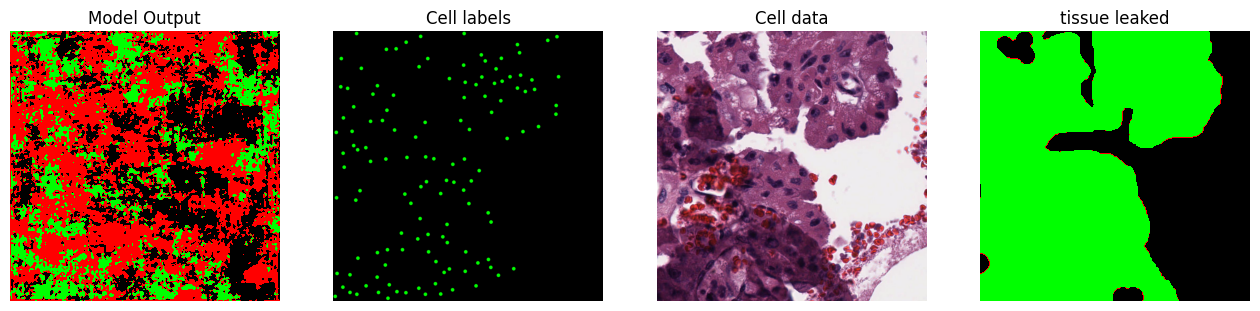

In [53]:
cell_image = inputs[0, :3]
tissue_labels = inputs[0, 3]
output_image = outputs.argmax(1)

# Setting the correct color for the labels
label_image = labels[0].permute((1, 2, 0)).numpy()
mask = np.all(label_image == [1, 0, 0], axis=-1)
label_image[mask] = [0, 0, 0]

plt.figure(figsize=(16, 8))  # Adjust the width and height as needed

plt.subplot(1, 4, 1)
plt.title("Model Output")
plt.axis("off")
plt.imshow(output_image[0], cmap=cmap)

plt.subplot(1, 4, 4)
plt.title("tissue leaked")
plt.imshow(tissue_labels, cmap=cmap)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Cell data")
plt.axis("off")
plt.imshow(cell_image.permute((1, 2, 0)))

plt.subplot(1, 4, 2)
plt.title("Cell labels")
plt.imshow(label_image*255)
plt.axis("off")


plt.show()